# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import random

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]
print(brain)

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [1]:
!pip -q install ./python
from unityagents import UnityEnvironment
import numpy as np
import torch
import random
random.seed(1)
torch.manual_seed(1)

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


In [2]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
class Qnetwork(nn.Module):
    def __init__(self, state_size, action_size,  fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Qnetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
class agent():
    def __init__(self, n_states, n_actions):
        self.state_size = n_states
        self.action_size = n_actions
        self.lr = 0.0005
       
        self.memory_size = 100000
        self.batch_size = 64
        self.update_frequency = 4
        self.GAMMA = 0.995
        self.TAU = 0.001

        self.epsilon_start = 1.0
        self.epsilon_end = 0.01
        self.annealing_steps = 200000
        self.epsilon_drop = (self.epsilon_start - self.epsilon_end) / self.annealing_steps
        self.epsilon = self.epsilon_start
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.qnetwork_local =  Qnetwork(n_states, n_actions).to(self.device)
        self.qnetwork_target = Qnetwork(n_states, n_actions).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)
        self.memory = replay_buffer(self.memory_size, self.batch_size, self.device)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_frequency
        
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.GAMMA * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


    def choose_action(self, observation):
        """Returns actions for given state as per current policy.
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(observation).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if random.random() < self.epsilon:
            if self.epsilon < self.epsilon_end:
                pass
            else:
                self.epsilon -= self.epsilon_drop
            return random.choice(np.arange(self.action_size))
        else:
            if self.epsilon < self.epsilon_end:
                pass
            else:
                self.epsilon -= self.epsilon_drop
            return np.argmax(action_values.cpu().data.numpy())

In [5]:
import random
from collections import deque, namedtuple
random.seed(1)

class replay_buffer():
    def __init__(self, memory_size,  batch_size, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.device = device
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
import matplotlib.pyplot as plt
def update():
    reward_list = []
    
    #training episode is 900 
    for episode in range(900):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        
        state = env_info.vector_observations[0]            # get the current state
       
        episode_reward = 0
       
        if len(reward_list) != 0 and len(reward_list)  % 100 == 0:
            print('episode is :{}, episilon is :{}'.format(episode, round(RL.epsilon,3) ))
            print('average reward of last 100 episode is {}'.format(round(np.average(reward_list[-100:]),3)))
       
            
        #if t reaches maximum 1000 and there will be another episode
        for t in range(1000):
            
          
            action = RL.choose_action(state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            RL.step(state,action, reward, next_state, done)
            
            state = next_state
            
            episode_reward += reward
            if done:
                reward_list.append(episode_reward)
                #print(episode_reward)
                break
        
           
    print('game over')
    print('episode is :{}, episilon is :{}'.format(episode, round(RL.epsilon,3) ))
    print('average reward of last 100 episode is {}'.format(round(np.average(reward_list[-100:]),3))) 
    torch.save(RL.qnetwork_local.state_dict(), 'checkpoint.pth')
    
    reward_list1 = np.array(reward_list)
    reward_list_average100 = np.mean(reward_list1.reshape((-1,100)), axis = 1)
    reward_list_average100 = list(reward_list_average100)
    
    labels = 'reward'
    plt.legend(labels)
    plt.ylabel('Reward')
    plt.xlabel('training episode')
    #plt.xlabel('training episode')
    plt.plot(reward_list1)
    #plt.plot(reward_list1)
    plt.show()
    
    #env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37
episode is :100, episilon is :0.851
average reward of last 100 episode is 0.16
episode is :200, episilon is :0.703
average reward of last 100 episode is 1.44
episode is :300, episilon is :0.554
average reward of last 100 episode is 3.23
episode is :400, episilon is :0.406
average reward of last 100 episode is 5.79
episode is :500, episilon is :0.257
average reward of last 100 episode is 8.43
episode is :600, episilon is :0.109
average reward of last 100 episode is 10.96
episode is :700, episilo

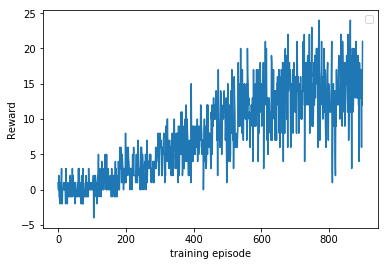

In [7]:
if __name__ == "__main__":
    # Setup environment of Naviagation
    env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]
    
    # number of agents in the environment
    print('Number of agents:', len(env_info.agents))

    # number of actions
    action_size = brain.vector_action_space_size
    print('Number of actions:', action_size)

    # examine the state space 
    state = env_info.vector_observations[0]
    print('States look like:', state)
    
    state_size = len(state)
    print('States have length:', state_size)

    RL = agent(state_size, action_size)
    
    update()
    

In [8]:
    RL.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score_list = []
    for i in range(100):
        score = 0  # initialize the score
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        while True:
            state = env_info.vector_observations[0]
            action = RL.choose_action(state)                      # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                #print("reward: {}".format(score), end='')
                print("reward: {}".format(score))
                score_list.append(score)
                break
        
    print('average reward of 100 episode is:', np.average(score_list))

reward: 16.0
reward: 15.0
reward: 15.0
reward: 18.0
reward: 19.0
reward: 18.0
reward: 23.0
reward: 13.0
reward: 12.0
reward: 15.0
reward: 16.0
reward: 10.0
reward: 11.0
reward: 19.0
reward: 15.0
reward: 11.0
reward: 14.0
reward: 13.0
reward: 9.0
reward: 15.0
reward: 11.0
reward: 22.0
reward: 18.0
reward: 20.0
reward: 15.0
reward: 15.0
reward: 14.0
reward: 20.0
reward: 26.0
reward: 8.0
reward: 15.0
reward: 15.0
reward: 15.0
reward: 11.0
reward: 24.0
reward: 22.0
reward: 20.0
reward: 15.0
reward: 10.0
reward: 13.0
reward: 13.0
reward: 22.0
reward: 18.0
reward: 19.0
reward: 18.0
reward: 18.0
reward: 11.0
reward: 19.0
reward: 15.0
reward: 21.0
reward: 17.0
reward: 17.0
reward: 15.0
reward: 22.0
reward: 12.0
reward: 13.0
reward: 17.0
reward: 14.0
reward: 15.0
reward: 16.0
reward: 12.0
reward: 14.0
reward: 19.0
reward: 16.0
reward: 12.0
reward: 15.0
reward: 9.0
reward: 15.0
reward: 22.0
reward: 14.0
reward: 21.0
reward: 21.0
reward: 15.0
reward: 16.0
reward: 18.0
reward: 15.0
reward: 17.0
re

In [9]:
    env.close()